In [3]:
using MLJ, DataFrames, CSV
import Logging

Logging.disable_logging(Logging.LogLevel(999));  # Disable info logs, but keep warnings

In [4]:
df = CSV.read("./data/401ksubs.csv", DataFrame)
#coerce!(df, Count => Continuous)
first(df, 5)

,net_tfa,age,inc,fsize,educ,db,marr,twoearn,e401,p401,pira
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,0,47,6765,2,8,0,0,0,0,0,0
2,1015,36,28452,1,16,0,0,0,0,0,0
3,-2000,37,3300,6,12,1,0,0,0,0,0
4,15000,58,52590,2,16,0,1,1,0,0,0
5,0,32,21804,1,11,0,0,0,0,0,0


In [2]:
#describe(df)

# Part A

Transformations

In [5]:
# Get correct types
df[!, 1:5] = coerce(df[!, 1:5], Count => Continuous)
df[!, 6:end] = coerce(df[!, 6:end], Count => Multiclass)
schema(df) |> pretty

┌─────────┬───────────────┬─────────────────────────────────┐
│ names   │ scitypes      │ types                           │
│ Symbol  │ Type          │ Type                            │
│ Unknown │ Unknown       │ Unknown                         │
├─────────┼───────────────┼─────────────────────────────────┤
│ net_tfa │ Continuous    │ Float64                         │
│ age     │ Continuous    │ Float64                         │
│ inc     │ Continuous    │ Float64                         │
│ fsize   │ Continuous    │ Float64                         │
│ educ    │ Continuous    │ Float64                         │
│ db      │ Multiclass{2} │ CategoricalValue{Int64, UInt32} │
│ marr    │ Multiclass{2} │ CategoricalValue{Int64, UInt32} │
│ twoearn │ Multiclass{2} │ CategoricalValue{Int64, UInt32} │
│ e401    │ Multiclass{2} │ CategoricalValue{Int64, UInt32} │
│ p401    │ Multiclass{2} │ CategoricalValue{Int64, UInt32} │
│ pira    │ Multiclass{2} │ CategoricalValue{Int64, UInt32} │
│ hown  

In [6]:
frac = 6000 / size(df)[1]  # Fraction of data that equals 6000 obs
df, df_test = partition(df, frac, rng=42)

X_cols = split("age,inc,fsize,educ,db,marr,twoearn,pira,hown", ",")
X, y = df[!, X_cols], df[!, :net_tfa]
println("Size of X = ",size(X))
first(X, 4)

Size of X = (6000, 9)


,age,inc,fsize,educ,db,marr,twoearn,pira,hown
,Float64,Float64,Float64,Float64,Cat…,Cat…,Cat…,Cat…,Cat…
1,43.0,47094.0,4.0,14.0,0,1,0,0,1
2,31.0,30315.0,4.0,13.0,0,1,0,0,1
3,27.0,38640.0,2.0,16.0,1,1,1,0,0
4,62.0,13317.0,1.0,11.0,0,0,0,0,1


### 1. Estimate $E[net\_tfa]$

In [1]:
mean(y)

LoadError: syntax: incomplete: premature end of input

### 2. Using linear regression estimate $E[net\_tfa|X = \{age, inc, fsize, educ, db, marr, twoearn, pira, hown\}]$

In [68]:
LinearRegressor = (@load LinearRegressor pkg=MLJLinearModels verbosity=0)()
lm_pipe = ContinuousEncoder(drop_last=true) |> LinearRegressor
lm = machine(lm_pipe, X, y) |> fit!;

In [69]:
# Display model results
fp = fitted_params(lm_mach).linear_regressor
coefs = fp.coefs
intercept = fp.intercept
println("Intercept: $(round(intercept, sigdigits=3))")
for (name, val) in coefs
    println("$(rpad(name, 8)):  $(round(val, sigdigits=3))")
end

LoadError: UndefVarError: lm_mach not defined

### 3. Lasso

In [10]:
using StatsModels: @formula
import StatsModels as sm

""" Equivalent to modelmatrix but returns a DataFrame"""
function modelframe(formula::sm.FormulaTerm, data)
    f = formula
    f = sm.apply_schema(f, sm.schema(f, data))
    resp, pred = sm.modelcols(f, X);
    DataFrame(pred, sm.coefnames(f)[2])
end

#X_flex = modelframe(@formula(0 ~ age+inc+fsize+educ+db+marr+twoearn+pira+hown), X)
#first(X_flex, 3)

import MLJLinearModels ✔


,age,inc,fsize,educ,db: 1,marr: 1,twoearn: 1,pira: 1,hown: 1
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,43.0,47094.0,4.0,14.0,0.0,1.0,0.0,0.0,1.0
2,31.0,30315.0,4.0,13.0,0.0,1.0,0.0,0.0,1.0
3,27.0,38640.0,2.0,16.0,1.0,1.0,1.0,0.0,0.0


In [11]:
LassoRegressor = @load LassoRegressor pkg=MLJLinearModels

import MLJLinearModels ✔


MLJLinearModels.LassoRegressor

In [64]:
""" Nonlinear transformations of data - take interactions and add higher-order terms """
function nl_transform(df)
    # Take interaction terms of all variables
    cols = names(df)
    cat_cols = [:db, :marr, :twoearn, :pira, :hown]
    df[!, cat_cols] = coerce(df[!, cat_cols], Multiclass => Continuous)  # Transform Categorical to Continuous
    for col1 in cols
        for col2 in cols
            if col1 == col2
                continue  # Avoid taking interaction when both cols are the same
            else
                df[!, col1*"_"*col2] = df[!, col1] .* df[!, col2]
            end
        end
    end
    
    df[!, cat_cols] = coerce(df[!, cat_cols], Continuous => Multiclass)  # Convert back to Categorical type
    
    # Add a second and third exponent of all numerical columns
    num_cols = [:age, :inc, :fsize, :educ]
    for p in [x->x.^2, x->x.^3]
        transform!(df, num_cols .=> p)
    end
    df
end
   
X_flex = copy(X)
nl_transform(X_flex)

first(X_flex, 3)

,age,inc,fsize,educ,db,marr,twoearn,pira,hown,age_inc
,Float64,Float64,Float64,Float64,Cat…,Cat…,Cat…,Cat…,Cat…,Float64
1,43.0,47094.0,4.0,14.0,1.0,2.0,1.0,1.0,2.0,2.02504e6
2,31.0,30315.0,4.0,13.0,1.0,2.0,1.0,1.0,2.0,939765.0
3,27.0,38640.0,2.0,16.0,2.0,2.0,2.0,1.0,1.0,1.04328e6


In [66]:
# Standardize numerical variables then onehot encode categorical variables
transformer = Standardizer() |> OneHotEncoder()
mach = fit!(machine(transformer, X_flex))
X_flex = MLJ.transform(mach, X_flex);
first(X_flex, 3)

,age,inc,fsize,educ,db__1.0,db__2.0,marr__1.0,marr__2.0
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.18438,0.408248,0.73133,0.280414,0.608884,-0.608884,-0.813314,0.813314
2,-0.973723,-0.267984,0.73133,-0.0701765,0.608884,-0.608884,-0.813314,0.813314
3,-1.35976,0.0675325,-0.557925,0.981595,-1.64207,1.64207,-0.813314,0.813314


In [100]:
r  = range(LassoRegressor(), :(lambda), lower=50, upper=1000)
tm = TunedModel(model=LassoRegressor(), ranges=r, tuning=Grid(resolution=50),
                resampling=CV(nfolds=5, rng=42), measure=rms)

lasso_tm = machine(tm, X_flex, y) |> fit!
best_mdl = fitted_params(lasso_tm).best_model

# Print results
coefs, intercept = fitted_params(lasso_tm).best_fitted_params

# Get non-zero coefs
coef_vals = [c[2] for c in coefs]

println("Opimtal penalty: ", round(best_mdl.lambda, sigdigits=4))
println("Pct. variables set to zero: ", sum(coef_vals .≈ 0) / length(coefs) )
@show intercept
coefs[.~(coef_vals .≈ 0)]

Evaluating over 50 metamodels:  14%[===>                     ]  ETA: 0:00:26┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\chris\.julia\packages\MLJLinearModels\eRCwo\src\fit\proxgrad.jl:64
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\chris\.julia\packages\MLJLinearModels\eRCwo\src\fit\proxgrad.jl:64
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\chris\.julia\packages\MLJLinearModels\eRCwo\src\fit\proxgrad.jl:64
Evaluating over 50 metamodels:  16%[====>                    ]  ETA: 0:00:29┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\chris\.julia\packages\MLJLinearModels\eRCwo\src\fit\proxgrad.jl:64
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\chris\.julia\packages\MLJLinearModels\eRCwo\src\fit\proxgrad.jl:64
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJL

Opimtal penalty: 166.3
Pct. variables set to zero: 0.6111111111111112
intercept = 18367.099758307315


35-element Vector{Pair{Symbol, Float64}}:
                   :age => -6131.1947771618625
      Symbol("db__1.0") => -171.06758919111294
      Symbol("db__2.0") => 171.06758919082782
 Symbol("twoearn__1.0") => -5548.728861183551
 Symbol("twoearn__2.0") => 5548.728861183551
               :age_inc => 13182.147910813303
             :age_fsize => -808.6945912816552
              :age_marr => -555.6291958761244
           :age_twoearn => -909.681548159699
              :age_pira => 7468.962691715774
               :inc_age => 13182.147910813303
             :inc_fsize => 60.2741927824427
           :inc_twoearn => -21496.567260624728
                        ⋮
           :twoearn_age => -909.681548159699
           :twoearn_inc => -21496.567260624728
          :twoearn_educ => 792.1121214293977
            :twoearn_db => 605.452301238719
              :pira_age => 7468.962691715774
              :pira_inc => 3333.1533454379824
            :pira_fsize => -222.49953059485807
               :p

### Ridge

In [104]:
RidgeRegressor = @load RidgeRegressor pkg=MLJLinearModels;

import MLJLinearModels ✔


In [105]:
r  = range(RidgeRegressor(), :(lambda), lower=0.0001, upper=100_000, scale=:log10)
tm = TunedModel(model=RidgeRegressor(), ranges=r, tuning=Grid(resolution=50),
                resampling=CV(nfolds=5, rng=42), measure=rms)

ridge_tm = machine(tm, X_flex, y) |> fit!
best_mdl = fitted_params(ridge_tm).best_model

# Print results
println("Opimtal penalty: ", round(best_mdl.lambda, sigdigits=4))
coefs, intercept = fitted_params(ridge_tm).best_fitted_params
@show intercept
coefs

Evaluating over 50 metamodels: 100%[=========================] Time: 0:00:01


Opimtal penalty: 0.016
intercept = 18367.1


90-element Vector{Pair{Symbol, Float64}}:
                   :age => -5256.72024495797
                   :inc => -3987.397694568995
                 :fsize => 4741.6268473711125
                  :educ => -3256.9444684314713
      Symbol("db__1.0") => -3420.7035619000503
      Symbol("db__2.0") => 3420.703561899973
    Symbol("marr__1.0") => -917.1610252566459
    Symbol("marr__2.0") => 917.1610252566982
 Symbol("twoearn__1.0") => -3787.4562687812845
 Symbol("twoearn__2.0") => 3787.45626878128
    Symbol("pira__1.0") => 3175.360414219944
    Symbol("pira__2.0") => -3175.3604142199997
    Symbol("hown__1.0") => 4221.268582133582
                        ⋮
              :hown_age => 1711.817576426756
              :hown_inc => 5563.940362585
            :hown_fsize => -191.24737660287963
             :hown_educ => 2485.626205705563
               :hown_db => 271.21319339145606
             :hown_marr => -150.80380835021958
          :hown_twoearn => 134.47881329788547
             :hown_

### Decision tree

In [ ]:
X = machine(ContinuousEncoder(), X) |> fit! |> MLJ.transform;  # Onehot-encode categorical variables

In [14]:
DecisionTreeRegressor = @load DecisionTreeRegressor pkg=DecisionTree

import MLJDecisionTreeInterface ✔


In [15]:
r1 = range(DecisionTreeRegressor(), :max_depth, lower=1, upper=5)
r2 = range(DecisionTreeRegressor(), :min_samples_leaf, lower=5, upper=100,)

tm = TunedModel(model=DecisionTreeRegressor(), ranges=[r1, r2], tuning=Grid(resolution=50),
                resampling=CV(nfolds=5, rng=42), measure=rms)

tree = machine(tm, X, y) |> fit!

fp = fitted_params(tree).best_model

Evaluating over 250 metamodels: 100%[=========================] Time: 0:00:09


DecisionTreeRegressor(
  max_depth = 3, 
  min_samples_leaf = 7, 
  min_samples_split = 2, 
  min_purity_increase = 0.0, 
  n_subfeatures = 0, 
  post_prune = false, 
  merge_purity_threshold = 1.0, 
  rng = Random._GLOBAL_RNG())

In [16]:
import DecisionTree
DecisionTree.print_tree(tree.fitresult.fitresult, 5)

Feature 2 < 162800.0 ?
├─ Feature 11 < 0.5 ?
    ├─ Feature 2 < 63690.0 ?
        ├─ 38363.41998060136 : 0/1031
        └─ 91199.4893111639 : 0/421
    └─ Feature 2 < 65620.0 ?
        ├─ 3674.0157498824638 : 0/4254
        └─ 37326.37455830388 : 0/283
└─ 551118.3636363636 : 0/11


### Random Forest

In [17]:
forest = EnsembleModel(model=DecisionTreeRegressor())

DeterministicEnsembleModel(
  model = DecisionTreeRegressor(
        max_depth = -1, 
        min_samples_leaf = 5, 
        min_samples_split = 2, 
        min_purity_increase = 0.0, 
        n_subfeatures = 0, 
        post_prune = false, 
        merge_purity_threshold = 1.0, 
        rng = Random._GLOBAL_RNG()), 
  atomic_weights = Float64[], 
  bagging_fraction = 0.8, 
  rng = Random._GLOBAL_RNG(), 
  n = 100, 
  acceleration = CPU1{Nothing}(nothing), 
  out_of_bag_measure = Any[])

In [18]:
r1 = range(forest, :(model.n_subfeatures), lower=1, upper=5)
r2 = range(forest, :bagging_fraction, lower=0.4, upper=1.0)
tm = TunedModel(model=forest, tuning=Grid(resolution=12),
                resampling=CV(nfolds=6), ranges=[r1, r2],
                measure=rms)

forest_tm = machine(tm, X, y) |> fit!

best_mdl = fitted_params(forest_tm).best_model
@show n_bootstraps = best_mdl.n
@show n_subfeatures = best_mdl.model.n_subfeatures
@show bagging_fraction = best_mdl.bagging_fraction;

Evaluating over 60 metamodels: 100%[=========================] Time: 0:01:50


n_bootstraps = best_mdl.n = 100
n_subfeatures = best_mdl.model.n_subfeatures = 5
bagging_fraction = best_mdl.bagging_fraction = 0.5636363636363636


In [20]:
using ShapML

function predict_function(model, data)
  data_pred = DataFrame(y_pred = predict(model, data))
  return data_pred
end

explain = copy(X)
reference = copy(X)

@time data_shap = ShapML.shap(explain = explain,
                        model = forest_tm,
                        predict_function = predict_function,
                        sample_size = 60,
                        seed = 42
                        );
first(data_shap, 2)

203.613855 seconds (1.07 G allocations: 332.090 GiB, 14.75% gc time, 2.17% compilation time)


,index,feature_name,feature_value,shap_effect,shap_effect_sd,intercept
,Int64,String,Float64?,Float64,Float64,Float64
1,1,age,43.0,-4965.69,15716.3,19708.8
2,2,age,31.0,-9616.06,18623.2,19708.8


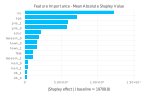

In [21]:
using Gadfly

function plot_shap(data_shap)
    data_plot = combine(groupby(data_shap, :feature_name), :shap_effect => (x -> mean(abs.(x)) ) => :mean_effect )
    data_plot = sort(data_plot, order(:mean_effect, rev = true))

    baseline = round(data_shap.intercept[1], digits = 1)

    p = plot(data_plot, y = :feature_name, x = :mean_effect, Coord.cartesian(yflip = true),
             Scale.y_discrete, Geom.bar(position = :dodge, orientation = :horizontal),
             Theme(bar_spacing = 1mm),
             Guide.xlabel("|Shapley effect| (baseline = $baseline)"), Guide.ylabel(nothing),
             Guide.title("Feature Importance - Mean Absolute Shapley Value"))
end


p = plot_shap(data_shap)

### Boosted trees

In [22]:
XGBR = @load XGBoostRegressor;

import MLJXGBoostInterface ✔


In [23]:
r1 = range(XGBR(), :num_round, lower=1, upper=20)
r2 = range(XGBR(), :max_depth, lower=1, upper=5)

tm = TunedModel(model=XGBR(), tuning=Grid(resolution=50),
                resampling=CV(nfolds=5 ,rng=42), ranges=[r1, r2],
                measure=rms)

xgb = machine(tm, X, y) |> fit!
best_mdl = fitted_params(xgb).best_model
@show num_round = best_mdl.num_round
@show max_depth = best_mdl.max_depth;

Evaluating over 100 metamodels: 100%[=========================] Time: 0:00:15


num_round = best_mdl.num_round = 17
max_depth = best_mdl.max_depth = 2


 10.712331 seconds (31.51 M allocations: 9.042 GiB, 10.13% gc time, 28.23% compilation time)


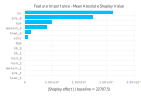

In [24]:
@time data_shap = ShapML.shap(explain = explain,
                        model = xgb,
                        predict_function = predict_function,
                        sample_size = 60,
                        seed = 42
                        );

plot_shap(data_shap)

### Neural net

In [33]:
import MLJFlux
import Flux
NeuralNetworkRegressor = @load NeuralNetworkRegressor;

import MLJFlux ✔


In [43]:
mutable struct MyNetworkBuilder <: MLJFlux.Builder
    n1::Int #Number of cells in the first hidden layer
    n2::Int #Number of cells in the second hidden layer
    dropout::Float64
    σ
end

MyNetworkBuilder1(; n1=16, n2=8, dropout=0.5, σ=Flux.relu) = MyNetworkBuilder1(n1, n2, dropout, σ)

function MLJFlux.build(model::MyNetworkBuilder, rng, n_in, n_out)
    n1, n2 = model.n1, model.n2
    dropout, σ = model.dropout, model.σ
    
    init = Flux.glorot_uniform(rng)
    layer1 = Flux.Dense(n_in, n1, σ, init=init)
    layer1_drop = Flux.Dropout(dropout)
    layer2 = Flux.Dense(n1, n2, σ, init=init)
    layer2_drop = Flux.Dropout(dropout)
    layer3 = Flux.Dense(model.n2, n_out, init=init)
    return Flux.Chain(layer1, layer1_drop, layer2, layer2_drop, layer3)
end

nnregressor = NeuralNetworkRegressor(builder=MyNetworkBuilder(), epochs=10)

NeuralNetworkRegressor(
  builder = MyNetworkBuilder1(
        n1 = 16, 
        n2 = 8, 
        dropout = 0.5, 
        σ = NNlib.relu), 
  optimiser = Flux.Optimise.Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()), 
  loss = Flux.Losses.mse, 
  epochs = 10, 
  batch_size = 1, 
  lambda = 0.0, 
  alpha = 0.0, 
  rng = Random._GLOBAL_RNG(), 
  optimiser_changes_trigger_retraining = false, 
  acceleration = CPU1{Nothing}(nothing))

In [44]:
nn = machine(nnregressor, X, y) |> fit!

Optimising neural net: 100%[=========================] Time: 0:01:28


Machine trained 1 time; caches data
  model: NeuralNetworkRegressor(builder = MyNetworkBuilder1(n1 = 16, …), …)
  args: 
    1:	Source @009 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @869 ⏎ `AbstractVector{Continuous}`


### Ensemble

In [108]:
# Compute predictions of all models, then stack them
MLmodels = [tree, forest_tm, xgb, nn]
M = zeros(length(y), 7)

M[:, 1] = precict(lm , df[!, X_cols])
M[:, 2] = precict(lasso_tm , X_flex)
M[:, 3] = precict(ridge_tm , X_flex)

for i in 4:length(MLmodels)
    M[:, i] = predict(MLmodels[i], X)
end
first(M, 3)

LoadError: UndefVarError: tree not defined

In [93]:
f(w) = (y .- M*w)' * (y .- M*w)

n_models = size(M)[2]
x0 = ones(n_models) * (1/n_models)

f (generic function with 1 method)

In [170]:
using IJulia, PyCall
@pyimport scipy.optimize as opt

py"""
import numpy as np
import scipy.optimize as opt
cons = {'type':'eq', 'fun': lambda w: np.sum(np.abs(w))-1}
cons1 = ({'type':'eq', 'fun': lambda w: np.sum(np.abs(w))-1},
        {'type':'ineq', 'fun': lambda w: np.array(w)})


res = opt.minimize($f, $x0, constraints=cons)
"""
py"res"

Dict{Any, Any} with 9 entries:
  "fun"     => 1.26452e13
  "nit"     => 67
  "nfev"    => 484
  "status"  => 0
  "message" => "Optimization terminated successfully"
  "x"       => [7.3639e-8, 0.999993, 7.47719e-6, -1.50228e-8]
  "jac"     => [-1.94629e12, -4.27382e12, -4.03734e12, -1.2208e11]
  "success" => true
  "njev"    => 67

## Mean-square forecast error of all models